In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re
import pandasql as ps
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
from sklearn.preprocessing import StandardScaler
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [69]:
# reading the datasets from the directory Datasets/SocioEconomic
# read the pop_stab dataframe up to 214 rows only
pop_stab =  pd.read_csv('../Datasets/SocioEconomic/political_stability_1996_2021.csv', nrows=214, na_values='..')
pop =  pd.read_csv('../Datasets/SocioEconomic/population_1960_2021.csv', na_values='..')
urban_pop =  pd.read_csv('../Datasets/SocioEconomic/Urban_pop_WorldBank_1960_2021.csv', skiprows=4)
gdp =  pd.read_csv('../Datasets/SocioEconomic/GDP_1960_2021.csv', na_values='..')
oil_prices = pd.read_csv('../Datasets/SocioEconomic/crude_oil_price_1983_2023.csv')
inflation =  pd.read_csv('../Datasets/SocioEconomic/Inflation_data_1970_2022.csv', encoding='ISO-8859-1')
co2_emission = pd.read_csv('../Datasets/SocioEconomic/co2_emission_2021.csv')
migration = pd.read_csv('../Datasets/SocioEconomic/migration_1960_2021.csv')
hdi_le = pd.read_csv('../Datasets/SocioEconomic/HDI_LE_1990_2021.csv')
country_codes = pd.read_csv('../Datasets/SocioEconomic/UN_country_code.csv')

## Cleaning Datasets
### Political Stability

The dataset under consideration contains information about the "Political Stability and Absence of Violence/Terrorism" index for various countries from the year 1996 to 2021. The index, coded as 'PV.EST', is measured on a scale from -2.5 to 2.5, with a higher value indicating more stable political conditions and less violence or terrorism. A lower score indicates a less stable political environment and higher levels of violence or terrorism.

The dataset includes 214 countries. Our data cleaning and preparation steps include:

- **Renaming columns**: The year columns are initially named in the format 'YYYY [YRYYYY]'. We rename these to just 'YYYY' for simplicity and ease of access.

- **Data type conversion**: We ensure that the values in the year columns are of numeric type (float) for proper analysis.

- **Handling missing years**: Our dataset does not include data for the years 1997, 1999, and 2001. We handle this by computing the missing values as the average of the previous and following years. This is done under the assumption that the political stability index changes smoothly over time.

- **Sorting columns**: After inserting the missing years, we sort our columns to maintain a chronological order of years.



In [70]:
# defining a list of countries
#countries_of_interest = ['USA', 'CHN', 'KOR']
# get all the rows for each country of interest
#pop_stab = pop_stab[pop_stab['Country Code'].isin(countries_of_interest)]
# renaming the columns by removing [YR]
pop_stab = pop_stab.rename(columns={col: re.sub(r'\s*\[YR.*\]', '', col) for col in pop_stab.columns[4:]})
# Change the type of year columns to float
for col in pop_stab.columns[4:]:
    pop_stab[col] = pop_stab[col].astype(float)

In [71]:
pop_stab = pop_stab.rename(columns={col: re.sub(r'\s*\[YR.*\]', '', col) for col in pop_stab.columns[4:]})


In [72]:
# As you can see above, certain years are missing from the columns
missing_years = [1997, 1999, 2001]

In [73]:
def insert_missing_years(df, missing_years):
    for year in missing_years:
        prev_year = str(year - 1)
        next_year = str(year + 1)

        # Check if previous and next year columns exist
        if prev_year in df.columns and next_year in df.columns:
            df[prev_year] = pd.to_numeric(df[prev_year], errors='coerce')
            df[next_year] = pd.to_numeric(df[next_year], errors='coerce')
            df[str(year)] = (df[prev_year] + df[next_year]) / 2
        else:
            print(f"Cannot compute for year {year}, adjacent years data are not available.")
        
    # Sort the columns
    non_year_cols = ["Country Name", "Country Code", "Series Name", "Series Code"]
    year_cols = [str(i) for i in sorted(int(col) for col in df.columns if col.isdigit())]
    cols = non_year_cols + year_cols
    
    return df.reindex(columns=cols)

pop_stab = insert_missing_years(pop_stab, missing_years)

In [74]:
pop_stab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  214 non-null    object 
 1   Country Code  214 non-null    object 
 2   Series Name   214 non-null    object 
 3   Series Code   214 non-null    object 
 4   1996          189 non-null    float64
 5   1997          189 non-null    float64
 6   1998          189 non-null    float64
 7   1999          189 non-null    float64
 8   2000          190 non-null    float64
 9   2001          190 non-null    float64
 10  2002          190 non-null    float64
 11  2003          200 non-null    float64
 12  2004          207 non-null    float64
 13  2005          207 non-null    float64
 14  2006          208 non-null    float64
 15  2007          208 non-null    float64
 16  2008          209 non-null    float64
 17  2009          212 non-null    float64
 18  2010          212 non-null    

In [75]:
pop_stab.loc[:, '1996':] = pop_stab.loc[:, '1996':].bfill(axis=1)

#### Population & Urban Population

##### Population
The dataset under consideration contains information about the total population of various countries from the year 1960 to 2021. For our purposes, we're interested in the population data for three specific countries: USA, China (CHN), and South Korea (KOR).

Our data cleaning and preparation steps for the population data include:

- **Country selection**: We're focusing our analysis on three specific countries (USA, CHN, KOR). We filter the population data to include only these countries.

- **Renaming columns**: The year columns in the population data are initially named in the format 'YYYY [YRYYYY]'. We rename these to just 'YYYY' for simplicity and ease of access.

- **Data type conversion**: We ensure that the values in the year columns are of numeric type (float) for proper analysis.

Once these steps are complete, we have a clean and concise dataframe that contains the population data for each year for the three countries of interest.


In [76]:
# get all the rows for each country of interest
#pop = pop[pop['Country Code'].isin(countries_of_interest)]
# removing the null values
pop = pop.dropna()
# renaming the columns by removing [YR]
pop = pop.rename(columns={col: re.sub(r'\s*\[YR.*\]', '', col) for col in pop.columns})
# Change the type of year columns to float
for col in pop.columns[4:]:
    pop[col] = pop[col].astype(float)

##### Urban Population Data

The dataset under consideration contains information about the percentage of the total population living in urban areas for various countries from the year 1960 to 2021. For our purposes, we're interested in the urban population data for three specific countries: USA, China (CHN), and South Korea (KOR).

Our data cleaning and preparation steps for the urban population data include:

- **Country selection**: We're focusing our analysis on three specific countries (USA, CHN, KOR). We filter the urban population data to include only these countries.

- **Data type conversion**: We ensure that the values in the year columns are of numeric type (float) for proper analysis.

Once these steps are complete, we have a clean and concise dataframe that contains the urban population data for each year for the three countries of interest.


In [77]:
# get all the rows for each country of interest
#urban_pop = urban_pop[urban_pop['Country Code'].isin(countries_of_interest)]
# removing the null values
urban_pop = urban_pop.dropna()
# Change the type of year columns to float
for col in urban_pop.columns[4:]:
    urban_pop[col] = urban_pop[col].astype(float)

### Human Development Index (HDI) and Life Expectancy (LE)

The dataset under consideration contains information about the Human Development Index (HDI) and Life Expectancy (LE) from the year 1990 to 2021. For our purposes, we're interested in the HDI and LE data for a set of specific countries.

Our data cleaning and preparation steps for the HDI and LE data include:

- **Filtering Columns**: We're interested in the data from 1996 to 2021, so we filter our dataset to include only these years. 

- **Renaming columns**: We rename the 'iso3' column to 'Country Code' and 'country' column to 'Country Name' for consistency with our other datasets.

- **Removing Prefix**: The columns in the dataset are initially named in the format 'hdi_YYYY' and 'le_YYYY' for HDI and LE respectively. We remove these prefixes for simplicity and ease of access.

Once these steps are complete, we have two clean and concise dataframes that contain the HDI and LE data for each year for our countries of interest.


In [78]:
# Filter the columns to include only those related to HDI
hdi_columns = ['iso3', 'country'] + [f'hdi_{year}' for year in range(1996, 2022)]
hdi_data = hdi_le[hdi_columns].copy()

# Rename the columns
hdi_data.rename(columns={'iso3': 'Country Code', 'country': 'Country Name'}, inplace=True)

# Remove 'hdi_' prefix from the columns in the HDI dataframe
hdi_data.columns = hdi_data.columns.str.replace('hdi_', '')

# Fill the missing values using backward fill
hdi_data.loc[:, '1996':] = hdi_data.loc[:, '1996':].bfill(axis=1)

# remove some invalid countries
hdi_data = hdi_data.dropna()

In [79]:
# Filter the columns to include only those related to Life expectancy
le_columns = ['iso3', 'country'] + [f'le_{year}' for year in range(1996, 2022)]
le_data = hdi_le[le_columns].copy()

# Rename the columns
le_data.rename(columns={'iso3': 'Country Code', 'country': 'Country Name'}, inplace=True)

# Remove 'le_' prefix from the columns in the Life expectancy dataframe
le_data.columns = le_data.columns.str.replace('le_', '')

### Gross Domestic Product

The GDP dataset under analysis contains information about the Gross Domestic Product for various countries for a range of years. GDP is a measure of the economic output of a country.

As with the "Political Stability" and "Human Development Index and Life Expectancy" datasets, we will focus on three specific countries: USA, China (CHN), and South Korea (KOR).

Our data cleaning and preparation steps for the GDP data include:

- **Country selection**: We're focusing our analysis on three specific countries (USA, CHN, KOR). We filter the GDP data to include only these countries.

- **Renaming columns**: The year columns in the GDP data are initially named in the format 'YYYY [YRYYYY]'. We rename these to just 'YYYY' for simplicity and ease of access.

- **Data type conversion**: We ensure that the values in the year columns are of numeric type (float) for proper analysis.

Again, it's important to visualize the data after cleaning to confirm that it's in the correct format and to identify any anomalies that might require further cleaning.


In [80]:
# get all the rows for each country of interest
#gdp = gdp[gdp['Country Code'].isin(countries_of_interest)]
# renaming the columns by removing [YR]
gdp = gdp.rename(columns={col: re.sub(r'\s*\[YR.*\]', '', col) for col in gdp.columns[4:]})
# Change the type of year columns to float
for col in gdp.columns[4:]:
    gdp[col] = gdp[col].astype(float)

# Filter columns
cols = [col for col in gdp.columns if (col.isdigit() and int(col) >= 1996) or not col.isdigit()]

# Select those columns from gdp
gdp = gdp[cols]

In [81]:
# Fill the null years using backward fill
gdp.loc[:, '1996':] = gdp.loc[:, '1996':].bfill(axis=1).ffill(axis=1)
# remocet the rest of null values
gdp = gdp.dropna()

### Crude Oil Prices

The dataset under consideration contains information about the crude oil prices from the year 1983 to 2023. The data includes the date of observation, the price of crude oil on that date, the percentage change in price from the previous date, and the absolute change in price from the previous date.

Our data cleaning and preparation steps for the crude oil prices data include:

- **Date conversion**: The 'date' column in the data is converted into datetime format for easier manipulation and analysis.

- **Year extraction**: A new 'year' column is created by extracting the year from the 'date' column. This allows for annual analysis of the data.

- **Calculating average annual price**: The data is then grouped by 'year', and the average price of crude oil for each year is calculated. This results in a new dataframe that shows the average price of crude oil for each year.

After these steps, we have a concise and tidy dataframe that contains the average price of crude oil for each year from 1983 to 2023.



In [82]:
# Convert the 'date' column to datetime format
oil_prices['date'] = pd.to_datetime(oil_prices['date'])

# Extract the year from the 'date' column and create a new 'year' column
oil_prices['Year'] = oil_prices['date'].dt.year

# Group the data by 'year' and calculate the average 'price'
avg_oil_price = oil_prices.groupby('Year')['price'].mean().reset_index()

# Display the average oil price data
avg_oil_price.head()

,Year,price
0,1983,30.468000
1,1984,29.240833
2,1985,27.873333
3,1986,14.413333
4,1987,19.036667


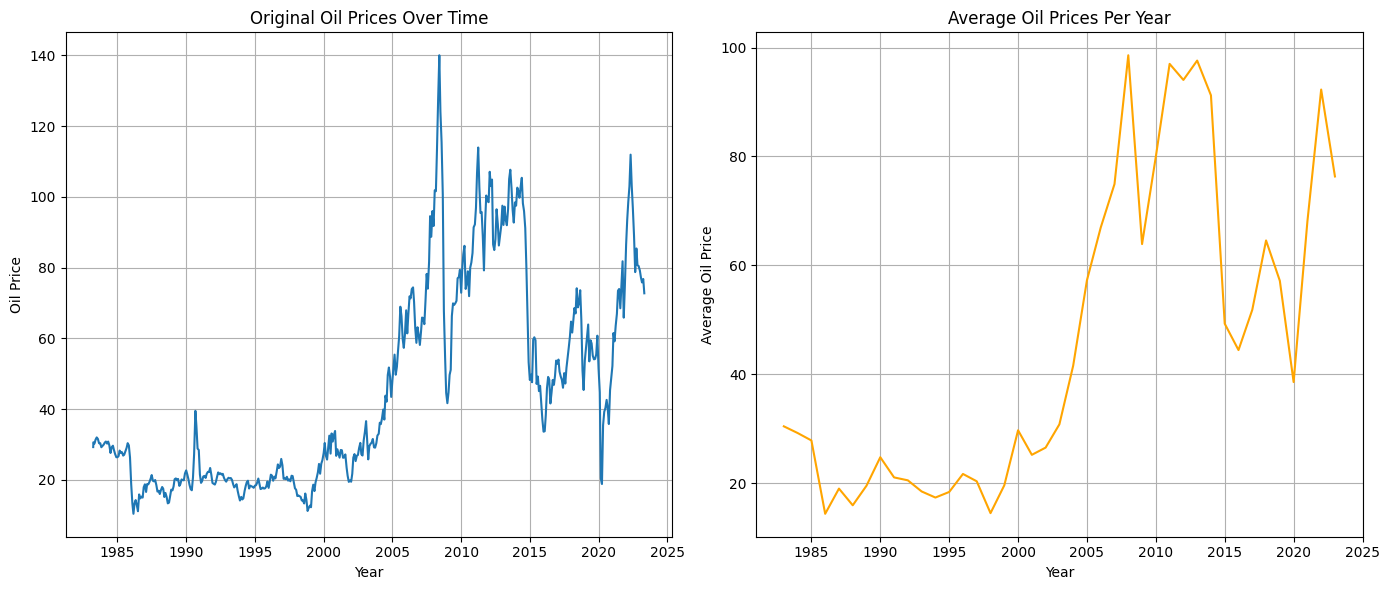

In [83]:
# Plot the original oil prices over time
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(oil_prices['date'], oil_prices['price'], label='Original Data')
plt.title('Original Oil Prices Over Time')
plt.xlabel('Year')
plt.ylabel('Oil Price')
plt.grid(True)

# Plot the average oil prices per year
plt.subplot(1, 2, 2)
plt.plot(avg_oil_price['Year'], avg_oil_price['price'], label='Average per Year', color='orange')
plt.title('Average Oil Prices Per Year')
plt.xlabel('Year')
plt.ylabel('Average Oil Price')
plt.grid(True)

plt.tight_layout()
plt.show()

### Inflation Data

The dataset under consideration contains information about various inflation indicators for a range of countries over a number of years. For our purposes, we're interested in the "Headline Consumer Price Inflation" for three specific countries: USA, China (CHN), and South Korea (KOR).

Our data cleaning and preparation steps for the inflation data include:

- **Country selection**: We're focusing our analysis on three specific countries (USA, CHN, KOR). We filter the inflation data to include only these countries.

- **Indicator selection**: We're interested in the "Headline Consumer Price Inflation" indicator. We filter the data to include only this indicator.

- **Removing unnecessary columns**: We remove columns that are not relevant to our analysis.

- **Renaming columns**: We rename the 'Country' column to 'Country Name' for consistency with our other datasets.

- **Data type conversion**: We ensure that the values in the year columns are of numeric type (float) for proper analysis.

Once these steps are complete, we have a clean and concise dataframe that contains the "Headline Consumer Price Inflation" for each year for the three countries of interest.

In [84]:
# get all the rows for each country of interest
#inflation = inflation[inflation['Country Code'].isin(countries_of_interest)]
# consider only Headline Consumer Price Inflation
inflation = inflation[inflation['Series Name'] == 'Headline Consumer Price Inflation']
inflation.drop(inflation.columns[-6:], axis=1, inplace=True)
# renaming the 'Country' column to be consistent
inflation = inflation.rename(columns={'Country': 'Country Name'})
# Change the type of year columns to float
for col in inflation.columns[5:]:
    inflation[col] = inflation[col].astype(float)

In [85]:
# Filter columns
cols = [col for col in inflation.columns if (col.isdigit() and int(col) >= 1996) or not col.isdigit()]

# Select those columns from inflation
inflation = inflation[cols]

In [86]:
# Select the columns that you want to operate on
year_cols = inflation.columns[5:]

# Replace NaN values with row mean
inflation.loc[:, year_cols] = inflation.loc[:, year_cols].apply(lambda x: x.fillna(x.mean()), axis=1)

# Get rid of the rest of the NaN values
inflation = inflation.dropna()

### Migration

In [87]:
migration.rename(columns={'country_code': 'Country Code', 'country_name': 'Country Name', 
                          'year': 'Year', 'value': 'Migration'}, inplace=True)

In [88]:
migration.head()

,Country Code,Country Name,Year,Migration
0,ABW,Aruba,1960,0.0
1,ABW,Aruba,1961,-569.0
2,ABW,Aruba,1962,-609.0
3,ABW,Aruba,1963,-646.0
4,ABW,Aruba,1964,-684.0


### CO2 Emissions

In [89]:
# Renaming the columns for consistency
co2_emission.rename(columns={'Annual CO₂ emissions': 'co2_emission', 
                             'Code': 'Country Code',
                             'Entity': 'Country Name'}, inplace=True)

# Getting the emission data after the year 1996 and onwards
co2_emission = co2_emission.query("Year >= 1996")

In [90]:
co2_emission.dropna(subset=['Country Code'])

,Country Name,Country Code,Year,co2_emission
47,Afghanistan,AFG,1996,1370104.00
48,Afghanistan,AFG,1997,1304152.00
49,Afghanistan,AFG,1998,1278504.00
50,Afghanistan,AFG,1999,1091640.00
51,Afghanistan,AFG,2000,1047127.94
...,...,...,...,...
31344,Zimbabwe,ZWE,2017,9596071.00
31345,Zimbabwe,ZWE,2018,11795478.00
31346,Zimbabwe,ZWE,2019,11114607.00
31347,Zimbabwe,ZWE,2020,10607897.00


### Melting and Combining dateframes

In [91]:
## Helper functions
def change_column_types(df, first_col, second_col):
    df[first_col] = df[first_col].astype(int)
    df[second_col] = df[second_col].astype(float)
    return df

In [92]:
# Drop unwanted columns
pop_stab = pop_stab.drop(['Series Name', 'Series Code'], axis=1)

# Melt the dataframe
pop_stab_melted = pop_stab.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="Stability")
pop_stab_melted = change_column_types(pop_stab_melted, 'Year', 'Stability')
pop_stab_melted = pop_stab_melted[(pop_stab_melted['Year'] >= 1996) & (pop_stab_melted['Year'] <= 2021)]

In [93]:
# Drop unwanted columns
pop = pop.drop(['Series Name', 'Series Code'], axis=1)

# Melt the dataframe
pop_melted = pop.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="Population")
pop_melted = change_column_types(pop_melted, 'Year', 'Population')
pop_melted = pop_melted[(pop_melted['Year'] >= 1996) & (pop_melted['Year'] <= 2021)]

In [94]:
# Drop unwanted columns
urban_pop = urban_pop.drop(['Indicator Name', 'Indicator Code'], axis=1)

# Melt the dataframe
urban_pop_melted = urban_pop.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="Urban_Population")
urban_pop_melted = change_column_types(urban_pop_melted, 'Year', 'Urban_Population')
urban_pop_melted = urban_pop_melted[(urban_pop_melted['Year'] >= 1996) & (urban_pop_melted['Year'] <= 2021)]

In [95]:
# Melt the dataframe
hdi_df_melted = hdi_data.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="HDI")
hdi_df_melted = change_column_types(hdi_df_melted, 'Year', 'HDI')
hdi_df_melted = hdi_df_melted[(hdi_df_melted['Year'] >= 1996) & (hdi_df_melted['Year'] <= 2021)]

In [96]:
life_exp_df_melted  =  le_data.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="Life_Expectancy")
life_exp_df_melted = change_column_types(life_exp_df_melted, 'Year', 'Life_Expectancy')
life_exp_df_melted = life_exp_df_melted[(life_exp_df_melted['Year'] >= 1996) & (life_exp_df_melted['Year'] <= 2021)]

In [97]:
# Drop unwanted columns
gdp = gdp.drop(['Series Name', 'Series Code'], axis=1)
gdp_melted  =  gdp.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="GDP")
gdp_melted = change_column_types(gdp_melted, 'Year', 'GDP')
gdp_melted = gdp_melted[(gdp_melted['Year'] >= 1996) & (gdp_melted['Year'] <= 2021)]

In [98]:
# Drop unwanted columns
inflation = inflation.drop(['IMF Country Code', 'Series Name', 'Indicator Type'], axis=1)
inflation_melted  =  inflation.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="Inflation")
inflation_melted = change_column_types(inflation_melted, 'Year', 'Inflation')
inflation_melted = inflation_melted[(inflation_melted['Year'] >= 1996) & (inflation_melted['Year'] <= 2021)]

In [99]:
avg_oil_price_melted = change_column_types(avg_oil_price, 'Year', 'price')
avg_oil_price_melted = avg_oil_price_melted[(avg_oil_price_melted['Year']>=1996) & (avg_oil_price_melted['Year']<=2021)]

In [100]:
# Filtering the co2_emission dataframe for the years 1996 to 2021
#co2_emission = co2_emission[(co2_emission['Year'] >= 1996) & (co2_emission['Year'] <= 2021)]

In [101]:
query = """
SELECT A.'Country Name' as 'Country Name', A.'Country Code', A.Year, A.Stability, B.Inflation, 
        C.Population, D.Urban_Population, E.HDI, F.Life_Expectancy, G.GDP, H.co2_emission, I.Migration
FROM pop_stab_melted AS A
INNER JOIN inflation_melted AS B ON A.'Country Code' = B.'Country Code' AND A.Year = B.Year
INNER JOIN pop_melted AS C ON A.'Country Code' = C.'Country Code' AND A.Year = C.Year
INNER JOIN urban_pop_melted AS D ON A.'Country Code' = D.'Country Code' AND A.Year = D.Year
INNER JOIN hdi_df_melted AS E ON A.'Country Code' = E.'Country Code' AND A.Year = E.Year
INNER JOIN life_exp_df_melted AS F ON A.'Country Code' = F.'Country Code' AND A.Year = F.Year
INNER JOIN gdp_melted AS G ON A.'Country Code' = G.'Country Code' AND A.Year = G.Year
INNER JOIN co2_emission AS H ON A.'Country Code' = H.'Country Code' AND A.Year = H.Year
INNER JOIN migration AS I ON A.'Country Code' = I.'Country Code' AND A.Year = I.Year
"""

merged_df = ps.sqldf(query, locals())

In [110]:
merged_df.head()

,Country Name,Country Code,Year,Stability,Inflation,Population,Urban_Population,HDI,Life_Expectancy,GDP,co2_emission,Migration
0,Afghanistan,AFG,1996,-2.417310,14.01,17106595.0,21.714,0.319,53.2433,3.854235e+09,1370104.0,27194.0
1,Albania,ALB,1996,-0.336625,12.80,3168033.0,39.473,0.645,74.5923,3.199641e+09,2017508.0,-65800.0
2,Algeria,DZA,1996,-1.783311,18.70,28984634.0,56.774,0.617,68.7493,4.694158e+10,96786280.0,-9849.0
3,Angola,AGO,1996,-2.061917,4146.01,14383350.0,45.346,0.364,46.0329,7.526447e+09,10423993.0,45356.0
4,Antigua and Barbuda,ATG,1996,0.717077,2.96,69798.0,33.590,0.802,73.8291,6.337296e+08,238160.0,478.0


In [161]:
# Prepare data
grouped = merged_df.groupby('Country Name')
time_series_data = []
country_names = []  # List to keep track of country names
for name, group in grouped:
    group = group.sort_values('Year')
    time_series_data.append(group[["Stability","Inflation","Population","Urban_Population","HDI","Life_Expectancy","GDP","Migration"]].values)
    country_names.append(name)  # Add country name to the list

In [162]:
# Data normalization
time_series_data = [TimeSeriesScalerMeanVariance().fit_transform(ts).squeeze() for ts in time_series_data]
X = to_time_series_dataset(time_series_data)

# Clustering
model = TimeSeriesKMeans(n_clusters=5, metric="dtw", max_iter=5, random_state=0)
model.fit(X)

TimeSeriesKMeans(max_iter=5, metric='dtw', n_clusters=5, random_state=0)

In [163]:
# Get the cluster assignments for each time series
labels = model.labels_

# Group country names by cluster
clusters = {i: [] for i in range(5)}
for country_name, label in zip(country_names, labels):
    clusters[label].append(country_name)

for i in range(5):
    print(f"Countries in cluster {i}: {', '.join(clusters[i])}")

Countries in cluster 0: Angola, Armenia, Azerbaijan, Bangladesh, Benin, Bhutan, Equatorial Guinea, Gambia, The, Ghana, Guinea, Haiti, India, Kenya, Lesotho, Moldova, Mongolia, Nigeria, Pakistan, Sao Tome and Principe, Sudan, Timor-Leste, Turkmenistan, Uzbekistan, Vietnam, Yemen, Rep., Zambia, Zimbabwe
Countries in cluster 1: Burundi, Congo, Dem. Rep., Ethiopia, Malawi, Myanmar, Sierra Leone, Tajikistan
Countries in cluster 2: Antigua and Barbuda, Argentina, Australia, Austria, Bahamas, The, Bahrain, Barbados, Belgium, Belize, Botswana, Brazil, Brunei Darussalam, Bulgaria, Canada, Chile, Colombia, Costa Rica, Croatia, Cyprus, Czech Republic, Denmark, Dominica, Dominican Republic, Ecuador, El Salvador, Estonia, Fiji, Finland, France, Gabon, Germany, Greece, Grenada, Hong Kong SAR, China, Hungary, Iceland, Iran, Islamic Rep., Ireland, Israel, Italy, Jamaica, Japan, Korea, Rep., Kuwait, Latvia, Lebanon, Libya, Liechtenstein, Lithuania, Luxembourg, Malaysia, Maldives, Malta, Marshall Island

In [157]:
X

array([[[-0.37988229, -0.37988228, -0.36645346, ..., -0.37988224,
          2.64572576, -0.37986094],
        [-0.37995618, -0.37995617, -0.36599147, ..., -0.37995614,
          2.64572367, -0.37995137],
        [-0.38003823, -0.38003821, -0.36552023, ..., -0.38003818,
          2.64572146, -0.38001017],
        ...,
        [-0.37882681, -0.37882681, -0.37278398, ..., -0.3788268 ,
          2.64574614, -0.37882811],
        [-0.37880332, -0.37880332, -0.37295162, ..., -0.37880331,
          2.64574646, -0.37877827],
        [-0.37912959, -0.37912959, -0.37092665, ..., -0.37912958,
          2.64574176, -0.37916716]],

       [[-0.37838317, -0.37838316, -0.37538892, ..., -0.3783831 ,
          2.64575003, -0.37844536],
        [-0.37855377, -0.37855373, -0.37433801, ..., -0.37855367,
          2.64574877, -0.37864211],
        [-0.37848397, -0.37848395, -0.37476773, ..., -0.37848388,
          2.64574934, -0.37856191],
        ...,
        [-0.37804427, -0.37804427, -0.37748392, ..., -